# Steepest Hill Climbing
---

In this notebook, we will train hill climbing with adaptive noise scaling with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [2]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Define the Policy

In [22]:
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)

class Policy():
    def __init__(self, s_size=4, a_size=2, w=None):
        self.s_size = s_size
        self.a_size = a_size
        if w is None:
            self.w = np.random.rand(s_size, a_size)  # weights for simple linear policy: state_space x action_space
        else:
            self.w = w
        
    def forward(self, state):
        x = np.dot(state, self.w)
        return np.exp(x) / sum(np.exp(x)) # Softmax
    
    def act(self, state):
        probs = self.forward(state)
        #action = np.random.choice(self.a_size, p=probs) # option 1: stochastic policy
        action = np.argmax(probs)              # option 2: deterministic policy
        return action

observation space: Box(4,)
action space: Discrete(2)


### 3. Train the Agent with Stochastic Policy Search

In [23]:
def run_episode(policy, env, gamma=.999, max_t=1000):
    """
        Implement the policy on the gym environment.
        
        Parameters
        ----------
        policy: Policy
            Policy being executed.
        env: Gym Environment
            Environment being executed
        gamma: float
            penalty for later rewards
    """
    rewards = []
    state = env.reset()
    for t in range(max_t):
        action = policy.act(state)
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            break 
    discounts = [gamma ** i for i in range(len(rewards) + 1)]
    R = sum([a * b for a, b in zip(discounts, rewards)])
    
    return [R, sum(rewards)]

In [24]:
env = gym.make('CartPole-v0')
env.seed(42)
np.random.seed(42)


def steep_hill_climbing(n_episodes=1000, max_t=1000, gamma=.9999, print_every=100, pop_size=10,
                        noise_scale=1.25, noise_mult=1, max_noise=2, min_noise=1e-4):
    """Implementation of steep hill climbingwith apdaptive noise.
        
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): number of noised agents
    """
    scores_deque = deque(maxlen=100)
    scores = []
    best_R = -np.Inf
    best_w = Policy().w
    all_scores = []
    for i_episode in range(1, n_episodes + 1):
        policies = [Policy(w=best_w + noise_mult * np.random.rand(*best_w.shape)) for p in range(pop_size)]
        scores_pop = np.array([run_episode(policy, env, gamma=gamma) for policy in policies])
        all_scores += list(scores_pop)
        best_index = scores_pop[:, 0].argmax()
        local_best_R = scores_pop[:, 0][best_index]
        local_best_w = policies[best_index].w
        if local_best_R >= best_R: # found better weights
            best_R = local_best_R
            best_w = local_best_w
            noise_mult = max(min_noise, noise_mult / noise_scale)
        else: # did not find better weights
            noise_mult = min(max_noise, noise_scale * noise_scale)
        scores_deque.append(scores_pop[:, 1][best_index])
        scores.append(scores_pop[:, 1][best_index])
#         import pdb;pdb.set_trace()
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(max(i_episode, i_episode-100), np.mean(scores_deque)))
            break
        
    return scores, Policy(w=best_w), all_scores
            
scores, policy, all_scores = steep_hill_climbing(pop_size=10)

Environment solved in 39 episodes!	Average Score: 195.08


### 4. Plot the Scores

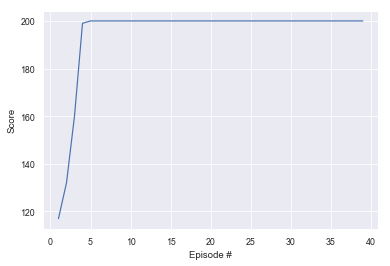

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In [28]:
env = gym.make('CartPole-v0')
state = env.reset()
for t in range(200):
    action = policy.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()